In [1]:
#Importing the required libraries and required data for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr

plt.rcParams["figure.figsize"] = (8, 5)
#transfermarkt data
players = pd.read_csv("../data/raw/players.csv")
valuations = pd.read_csv("../data/raw/player_valuations.csv")
#EAFC data
ea = pd.read_csv("../data/raw/EAFCmale_players.csv")

players.head()


,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
0,10,Miroslav,Klose,Miroslav Klose,2015,398,miroslav-klose,Poland,Opole,Germany,...,right,184.0,NaN,ASBW Sport Marketing,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/miroslav-klose...,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0
1,26,Roman,Weidenfeller,Roman Weidenfeller,2017,16,roman-weidenfeller,Germany,Diez,Germany,...,left,190.0,NaN,Neubauer 13 GmbH,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/roman-weidenfe...,L1,Borussia Dortmund,750000.0,8000000.0
2,65,Dimitar,Berbatov,Dimitar Berbatov,2015,1091,dimitar-berbatov,Bulgaria,Blagoevgrad,Bulgaria,...,NaN,NaN,NaN,CSKA-AS-23 Ltd.,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/dimitar-berbat...,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,1000000.0,34500000.0
3,77,NaN,Lúcio,Lúcio,2012,506,lucio,Brazil,Brasília,Brazil,...,NaN,NaN,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lucio/profil/s...,IT1,Juventus Football Club,200000.0,24500000.0
4,80,Tom,Starke,Tom Starke,2017,27,tom-starke,East Germany (GDR),Freital,Germany,...,right,194.0,NaN,IFM,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/tom-starke/pro...,L1,FC Bayern München,100000.0,3000000.0


In [2]:
#Checking the columns
players.columns, valuations.columns, ea.columns

(Index(['player_id', 'first_name', 'last_name', 'name', 'last_season',
        'current_club_id', 'player_code', 'country_of_birth', 'city_of_birth',
        'country_of_citizenship', 'date_of_birth', 'sub_position', 'position',
        'foot', 'height_in_cm', 'contract_expiration_date', 'agent_name',
        'image_url', 'url', 'current_club_domestic_competition_id',
        'current_club_name', 'market_value_in_eur',
        'highest_market_value_in_eur'],
       dtype='object'),
 Index(['player_id', 'date', 'market_value_in_eur', 'current_club_id',
        'player_club_domestic_competition_id'],
       dtype='object'),
 Index(['Unnamed: 0.1', 'Unnamed: 0', 'Rank', 'Name', 'OVR', 'PAC', 'SHO',
        'PAS', 'DRI', 'DEF', 'PHY', 'Acceleration', 'Sprint Speed',
        'Positioning', 'Finishing', 'Shot Power', 'Long Shots', 'Volleys',
        'Penalties', 'Vision', 'Crossing', 'Free Kick Accuracy',
        'Short Passing', 'Long Passing', 'Curve', 'Dribbling', 'Agility',
        'Bala

In [4]:
# filter 2024 for values in transfermarkt data
valuations["date"] = pd.to_datetime(valuations["date"])

valuations_2024 = valuations[valuations["date"].dt.year == 2024].copy()
valuations_2024["date"].describe()


count                            20404
mean     2024-08-02 12:07:58.494412800
min                2024-01-03 00:00:00
25%                2024-05-31 00:00:00
50%                2024-06-10 00:00:00
75%                2024-12-10 00:00:00
max                2024-12-30 00:00:00
Name: date, dtype: object

In [5]:
# get the last value for each player
valuations_2024_last = (
    valuations_2024
    .sort_values(["player_id", "date"])
    .groupby("player_id")
    .tail(1)
    .copy()
)

valuations_2024_last = valuations_2024_last.rename(columns={
    "market_value_in_eur": "market_value_2024_eur",
    "current_club_id": "club_id_2024",
    "player_club_domestic_competition_id": "league_2024"
})

valuations_2024_last.head(), valuations_2024_last.shape


(        player_id       date  market_value_2024_eur  club_id_2024 league_2024
 490320       3333 2024-12-16                1000000          1237         GB1
 479246       4391 2024-05-31                  50000           383         NL1
 491699       5336 2024-12-18                 300000         60949         GR1
 493008       7161 2024-12-20                5000000            15          L1
 491700       7825 2024-12-18                 600000          1047         IT1,
 (9596, 5))

In [6]:
#merging datas from transfermarkt
tm = pd.merge(
    valuations_2024_last,
    players,
    on="player_id",
    how="left"
)

tm.shape, tm.head()


((9596, 27),
    player_id       date  market_value_2024_eur  club_id_2024 league_2024  \
 0       3333 2024-12-16                1000000          1237         GB1   
 1       4391 2024-05-31                  50000           383         NL1   
 2       5336 2024-12-18                 300000         60949         GR1   
 3       7161 2024-12-20                5000000            15          L1   
 4       7825 2024-12-18                 600000          1047         IT1   
 
    first_name last_name                 name  last_season  current_club_id  \
 0       James    Milner         James Milner         2024             1237   
 1         Boy  Waterman         Boy Waterman         2023              383   
 2  Anastasios  Tsokanis  Anastasios Tsokanis         2024            60949   
 3       Jonas   Hofmann        Jonas Hofmann         2024               15   
 4        Pepe     Reina           Pepe Reina         2024             1047   
 
    ...   foot height_in_cm contract_expiration

In [7]:
# calculating age
tm["date_of_birth"] = pd.to_datetime(tm["date_of_birth"], errors="coerce")
tm["age_2024"] = (tm["date"] - tm["date_of_birth"]).dt.days / 365

# log values of market value
tm["log_value_2024"] = np.log1p(tm["market_value_2024_eur"])

tm[["market_value_2024_eur", "log_value_2024", "age_2024"]].describe()


,market_value_2024_eur,log_value_2024,age_2024
count,9.596000e+03,9596.000000,9595.000000
mean,4.363058e+06,13.860398,25.869387
std,1.081429e+07,1.675182,4.720310
min,1.000000e+04,9.210440,16.265753
25%,3.000000e+05,12.611541,22.072603
50%,9.000000e+05,13.710151,25.282192
75%,3.000000e+06,14.914123,29.143836
max,2.000000e+08,19.113828,43.227397


In [8]:
# eliminating duplicate names to manage data easily
tm["name_clean"] = tm["name"].str.lower().str.strip()
ea["name_clean"] = ea["Name"].str.lower().str.strip()
ea_name_counts = ea["name_clean"].value_counts()
unique_ea_names = ea_name_counts[ea_name_counts == 1].index
ea_unique = ea[ea["name_clean"].isin(unique_ea_names)].copy()
ea_unique.shape, ea.shape


((15919, 59), (16161, 59))

In [9]:
#merging data
merged = pd.merge(
    tm,
    ea_unique[[
        "name_clean", "OVR", "PAC", "SHO", "PAS", "DRI", "DEF", "PHY",
        "Position", "Age", "Nation", "League", "Team"
    ]],
    on="name_clean",
    how="inner"
)

merged.shape, merged.head()


((5029, 42),
    player_id       date  market_value_2024_eur  club_id_2024 league_2024  \
 0       3333 2024-12-16                1000000          1237         GB1   
 1       7825 2024-12-18                 600000          1047         IT1   
 2       8246 2024-05-29                 300000             3          L1   
 3      12029 2024-12-10                 100000          1421         FR1   
 4      12282 2024-12-27                2000000         12321         ES1   
 
   first_name last_name             name  last_season  current_club_id  ...  \
 0      James    Milner     James Milner         2024             1237  ...   
 1       Pepe     Reina       Pepe Reina         2024             1047  ...   
 2    Philipp    Pentke   Philipp Pentke         2023                3  ...   
 3    Ludovic   Butelle  Ludovic Butelle         2024             1421  ...   
 4      Daley     Blind      Daley Blind         2024            12321  ...   
 
   SHO PAS DRI DEF PHY Position Age   Nation   

In [10]:
# Cleaning NAs
merged = merged.dropna(subset=["OVR", "market_value_2024_eur", "age_2024"])

merged.shape


(5029, 42)

In [11]:
#creating the core dataset
important_cols = [
    "player_id",
    "name",          # Transfermarkt name
    "Name",          # EA name
    "name_clean",

    # EA ratings
    "OVR", "PAC", "SHO", "PAS", "DRI", "DEF", "PHY",
    "Position", "Age", "Nation", "League", "Team",

    # Transfermarkt info
    "position", "sub_position",
    "age_2024",
    "country_of_citizenship",
    "current_club_name",
    "league_2024",
    "current_club_domestic_competition_id",

    # Market value
    "market_value_2024_eur",
    "log_value_2024"
]

cols_to_keep = [c for c in important_cols if c in merged.columns]

merged_core = merged[cols_to_keep].copy()
merged_core.head(), merged_core.shape


(   player_id             name       name_clean  OVR  PAC  SHO  PAS  DRI  DEF  \
 0       3333     James Milner     james milner   75   50   70   78   74   74   
 1       7825       Pepe Reina       pepe reina   76   75   75   77   74   45   
 2       8246   Philipp Pentke   philipp pentke   66   65   66   62   67   31   
 3      12029  Ludovic Butelle  ludovic butelle   66   64   68   62   65   32   
 4      12282      Daley Blind      daley blind   80   36   62   83   77   83   
 
    PHY  ...            Team    position      sub_position   age_2024  \
 0   73  ...        Brighton    Midfield  Central Midfield  38.975342   
 1   77  ...            Como  Goalkeeper        Goalkeeper  42.328767   
 2   66  ...      1. FC Köln  Goalkeeper        Goalkeeper  39.104110   
 3   69  ...  Stade de Reims  Goalkeeper        Goalkeeper  41.717808   
 4   70  ...       Girona FC    Defender       Centre-Back  34.827397   
 
   country_of_citizenship                       current_club_name league

In [12]:
#saving new datasets
merged.to_csv("../data/processed/merged_ea_tm_2024_full.csv", index=False)
merged_core.to_csv("../data/processed/merged_ea_tm_2024_core.csv", index=False)


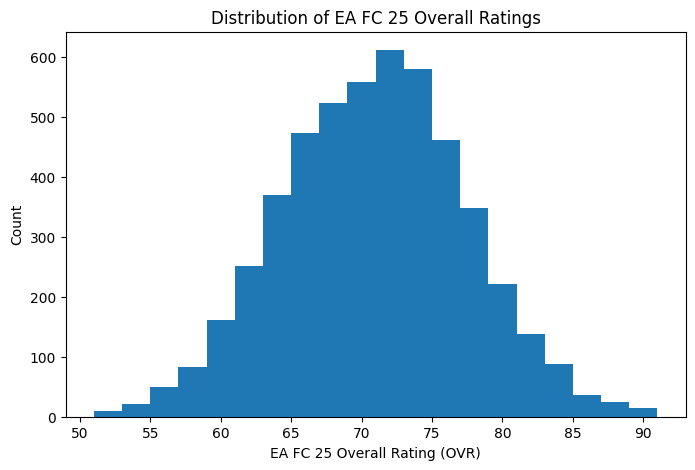

In [13]:
#rating distributions
merged_core[["OVR", "market_value_2024_eur", "log_value_2024", "age_2024"]].describe()
plt.hist(merged_core["OVR"], bins=20)
plt.xlabel("EA FC 25 Overall Rating (OVR)")
plt.ylabel("Count")
plt.title("Distribution of EA FC 25 Overall Ratings")
plt.show()


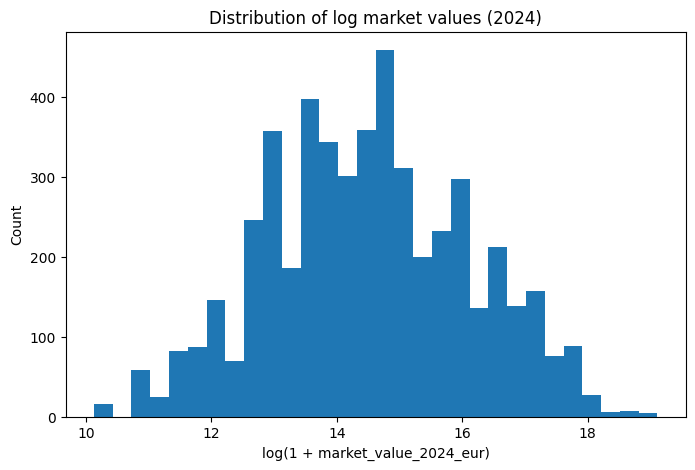

In [14]:
#logged market value distributions
plt.hist(merged_core["log_value_2024"], bins=30)
plt.xlabel("log(1 + market_value_2024_eur)")
plt.ylabel("Count")
plt.title("Distribution of log market values (2024)")
plt.show()


In [15]:
#avg ratings by position
pos_mean = (
    merged_core
    .groupby("Position")[["OVR", "market_value_2024_eur"]]
    .mean()
    .sort_values("market_value_2024_eur", ascending=False)
)

pos_mean


,OVR,market_value_2024_eur
Position,,
RW,71.608696,1.415348e+07
LW,70.898305,1.093008e+07
CAM,70.698997,8.733863e+06
CDM,71.501326,7.935809e+06
ST,70.385991,7.567996e+06
CM,70.223491,7.377855e+06
RM,70.677419,7.137903e+06
CB,70.704918,6.610820e+06
LM,70.194444,6.298958e+06


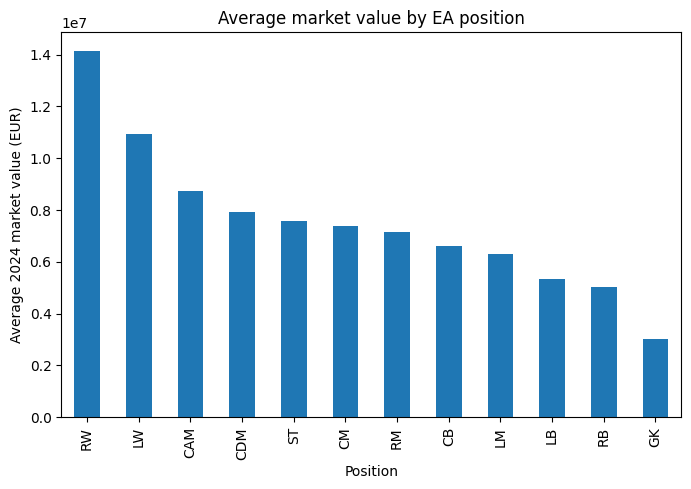

In [16]:
pos_mean["market_value_2024_eur"].plot(kind="bar")
plt.ylabel("Average 2024 market value (EUR)")
plt.title("Average market value by EA position")
plt.show()


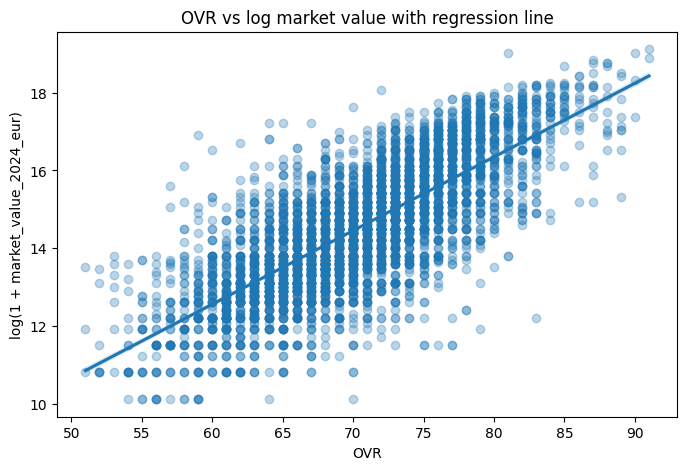

In [18]:
# overall vs logged values in scatter plot
sns.regplot(data=merged_core, x="OVR", y="log_value_2024", scatter_kws={"alpha":0.3})
plt.xlabel("OVR")
plt.ylabel("log(1 + market_value_2024_eur)")
plt.title("OVR vs log market value with regression line")
plt.show()


In [19]:
#Is there a meaningful relation between overall rating and market value?
corr, p_value = pearsonr(merged_core["OVR"], merged_core["log_value_2024"])
corr, p_value


(np.float64(0.7681719007563781), np.float64(0.0))

In [20]:
#Are +85 rating players more valuable than -80 players in meaningful way?
high = merged_core.loc[merged_core["OVR"] >= 85, "log_value_2024"]
low  = merged_core.loc[merged_core["OVR"] < 80, "log_value_2024"]

len(high), len(low)
t_stat, p_val = stats.ttest_ind(high, low, equal_var=False)
t_stat, p_val, high.mean(), low.mean()


(np.float64(32.996771263591825),
 np.float64(6.60714525904411e-49),
 np.float64(17.6532972105721),
 np.float64(14.335522615550994))

In [21]:
#In which positions rating affect market value more?

for pos, count in merged_core["Position"].value_counts().items():
    subset = merged_core[merged_core["Position"] == pos].dropna(subset=["OVR", "log_value_2024"])



    c, p = pearsonr(subset["OVR"], subset["log_value_2024"])
    print(pos, "| n =", len(subset), "| corr =", round(c, 3), "| p =", p)


CB | n = 915 | corr = 0.752 | p = 3.362711557006864e-167
ST | n = 671 | corr = 0.775 | p = 3.194706995526169e-135
CM | n = 613 | corr = 0.787 | p = 2.0967068982728616e-130
GK | n = 579 | corr = 0.808 | p = 9.90123249524041e-135
RB | n = 387 | corr = 0.757 | p = 2.910002786934951e-73
CDM | n = 377 | corr = 0.755 | p = 7.471196201554507e-71
LB | n = 357 | corr = 0.756 | p = 3.033902295273371e-67
RM | n = 310 | corr = 0.785 | p = 3.86156033409321e-66
CAM | n = 299 | corr = 0.757 | p = 8.397689812047989e-57
LM | n = 288 | corr = 0.771 | p = 5.609642152802709e-58
LW | n = 118 | corr = 0.802 | p = 9.402581943101325e-28
RW | n = 115 | corr = 0.773 | p = 4.6654982269961066e-24


In [23]:
#most undervalued 10 players
from scipy.stats import linregress

df = merged_core.dropna(subset=["OVR", "log_value_2024", "market_value_2024_eur"]).copy()

# eliminate low ratings
df = df[df["OVR"] >= 80]
slope, intercept, r_val, p_val, std_err = linregress(df["OVR"], df["log_value_2024"])
print("slope:", slope, "intercept:", intercept, "R:", r_val, "p:", p_val)
df["pred_log_value"] = intercept + slope * df["OVR"]
df["value_gap"] = df["log_value_2024"] - df["pred_log_value"]

undervalued_reg = (
    df.sort_values("value_gap")   # küçükten büyüğe
      .head(10)
)

cols_show = [c for c in ["Name", "name", "OVR", "market_value_2024_eur",
                         "log_value_2024", "pred_log_value", "value_gap",
                         "Position"] if c in df.columns]

undervalued_reg[cols_show]


slope: 0.17410389550514255 intercept: 2.4723001379685154 R: 0.40788245321012767 p: 5.500931231305609e-17


,name,OVR,market_value_2024_eur,log_value_2024,pred_log_value,value_gap,Position
4640,Rafa,83,200000,12.206078,16.922923,-4.716846,CAM
15,Kasper Schmeichel,80,750000,13.527830,16.400612,-2.872782,GK
96,Nicolás Otamendi,81,1000000,13.815512,16.574716,-2.759204,CB
120,Fernando Muslera,81,1000000,13.815512,16.574716,-2.759204,GK
4988,Alisson,89,4500000,15.319588,17.967547,-2.647959,GK
62,Yann Sommer,87,4000000,15.201805,17.619339,-2.417534,GK
170,Iago Aspas,84,2500000,14.731802,17.097027,-2.365226,ST
16,Manuel Neuer,86,4000000,15.201805,17.445235,-2.243430,GK
472,Francesco Acerbi,84,3000000,14.914123,17.097027,-2.182904,CB
28,Edin Džeko,82,2200000,14.603968,16.748820,-2.144851,ST


C:\Users\tolga\AppData\Local\Temp\ipykernel_29784\3621282533.py:14: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pos_value_ovr_pivot = df.pivot_table(


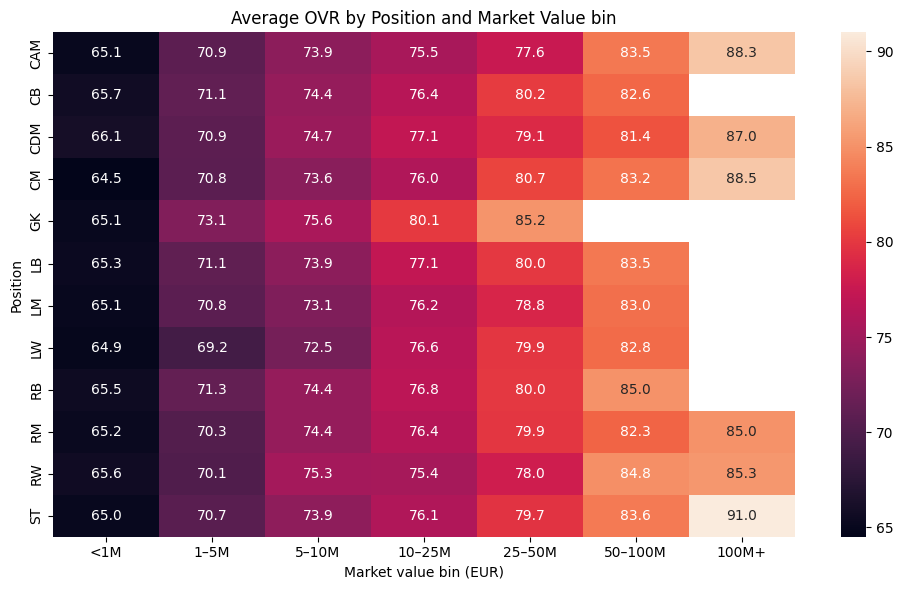

In [ ]:
#heapmap by position and market value
df = merged_core.dropna(subset=["Position", "market_value_2024_eur"]).copy()


value_bins = [0, 1_000_000, 5_000_000, 10_000_000, 25_000_000,
              50_000_000, 100_000_000, df["market_value_2024_eur"].max()]

value_labels = ["<1M", "1–5M", "5–10M", "10–25M", "25–50M", "50–100M", "100M+"]

df["value_bin"] = pd.cut(df["market_value_2024_eur"],
                         bins=value_bins,
                         labels=value_labels,
                         include_lowest=True)

pos_value_ovr_pivot = df.pivot_table(
    index="Position",
    columns="value_bin",
    values="OVR",
    aggfunc="mean"
)

plt.figure(figsize=(10, 6))
sns.heatmap(pos_value_ovr_pivot, annot=True, fmt=".1f")
plt.title("Average OVR by Position and Market Value bin")
plt.ylabel("Position")
plt.xlabel("Market value bin (EUR)")
plt.tight_layout()
plt.show()



In [26]:
#Do playersmarket value change by their position?
from scipy.stats import f_oneway, kruskal

df_pos = merged_core.dropna(subset=["Position", "log_value_2024"]).copy()

groups = []
labels = []

for pos, count in df_pos["Position"].value_counts().items():
    subset = df_pos[df_pos["Position"] == pos]["log_value_2024"]
    

    
    groups.append(subset)
    labels.append(pos)

print("Included positions:", labels)

# 1) One-way ANOVA
F_stat, p_anova = f_oneway(*groups)
print("ANOVA F =", F_stat, "p =", p_anova)

# 2) Kruskal-Wallis
H_stat, p_kruskal = kruskal(*groups)
print("Kruskal H =", H_stat, "p =", p_kruskal)


Included positions: ['CB', 'ST', 'CM', 'GK', 'RB', 'CDM', 'LB', 'RM', 'CAM', 'LM', 'LW', 'RW']
ANOVA F = 26.90989714821123 p = 3.148311277014433e-55
Kruskal H = 242.95993607433314 p = 8.309737611362306e-46


C:\Users\tolga\AppData\Local\Temp\ipykernel_29784\4279655271.py:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  age_value_pivot = df_age.pivot_table(


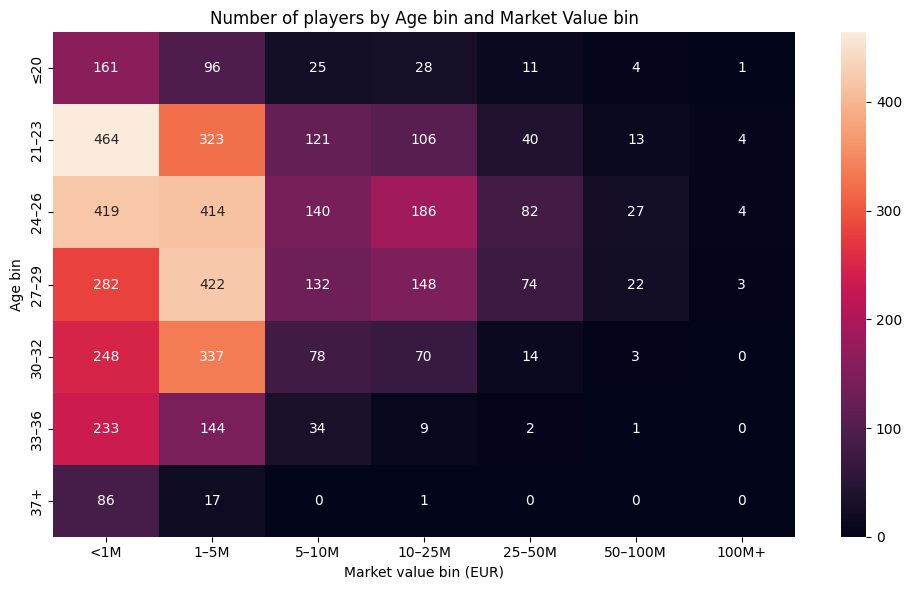

In [27]:
#heatmap by age and market value
df_age = merged_core.dropna(subset=["age_2024", "market_value_2024_eur"]).copy()


age_bins = [16, 20, 23, 26, 29, 32, 36, 45]
age_labels = ["≤20", "21–23", "24–26", "27–29", "30–32", "33–36", "37+"]

df_age["age_bin"] = pd.cut(df_age["age_2024"],
                           bins=age_bins,
                           labels=age_labels,
                           include_lowest=True)


value_bins = [0, 1_000_000, 5_000_000, 10_000_000, 25_000_000,
              50_000_000, 100_000_000, df_age["market_value_2024_eur"].max()]
value_labels = ["<1M", "1–5M", "5–10M", "10–25M", "25–50M", "50–100M", "100M+"]

df_age["value_bin"] = pd.cut(df_age["market_value_2024_eur"],
                             bins=value_bins,
                             labels=value_labels,
                             include_lowest=True)


age_value_pivot = df_age.pivot_table(
    index="age_bin",
    columns="value_bin",
    values="player_id",
    aggfunc="count",
    fill_value=0
)

plt.figure(figsize=(10, 6))
sns.heatmap(age_value_pivot, annot=True, fmt="d")
plt.title("Number of players by Age bin and Market Value bin")
plt.ylabel("Age bin")
plt.xlabel("Market value bin (EUR)")
plt.tight_layout()
plt.show()


In [28]:
#do age afftect the market value?

df_age = merged_core.dropna(subset=["age_2024", "log_value_2024"]).copy()

corr_age, p_corr_age = pearsonr(df_age["age_2024"], df_age["log_value_2024"])
corr_age, p_corr_age


(np.float64(-0.06289732951873235), np.float64(8.055519452897237e-06))